<a href="https://colab.research.google.com/github/farhanezi/AI-MIDTERM-PROJECT/blob/main/BART_Model_Implementation_for_Headline_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets accelerate sentencepiece evaluate pandas rouge_score -U

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

Menggunakan device: cuda


In [ ]:
# SEL 2: SETUP GLOBAL & MUAT DATASET STABIL (CNN_DAILYMAIL)

from transformers import BartForConditionalGeneration, AutoTokenizer, DataCollatorForSeq2Seq
from datasets import load_dataset, DatasetDict
import numpy as np
import evaluate

# --- Konfigurasi ---
MODEL_NAME = "facebook/bart-base"
model = BartForConditionalGeneration.from_pretrained(MODEL_NAME).to(device) # Pindah model ke GPU
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# --- MUAT DATASET CNN_DAILYMAIL ---
print("Memuat dataset stabil: cnn_dailymail...")
raw_datasets = load_dataset("cnn_dailymail", "3.0.0")

# Ambil subset kecil dari split train dan validation untuk mempercepat training
train_subset = raw_datasets['train'].select(range(10000))
validation_subset = raw_datasets['validation'].select(range(1000))
test_subset = raw_datasets['test'].select(range(1000))

raw_datasets = DatasetDict({
    'train': train_subset,
    'validation': validation_subset,
    'test': test_subset
})

print("Struktur dataset berhasil dimuat!")

Memuat dataset stabil: cnn_dailymail...
Struktur dataset berhasil dimuat!


In [ ]:
# SEL 3: PREPROCESSING & TOKENISASI DATA

MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 150

# --- Definisi Fungsi Preprocessing ---
def preprocess_function(examples):
    # Tokenisasi Input ('article')
    model_inputs = tokenizer(
        examples["article"], max_length=MAX_INPUT_LENGTH, truncation=True
    )

    # Tokenisasi Target ('highlights')
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["highlights"], max_length=MAX_TARGET_LENGTH, truncation=True
        )

    # Gabungkan dan ganti padding label dengan -100
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Aplikasikan fungsi preprocessing (menggunakan 'raw_datasets')
print("Memulai tokenisasi data...")
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

# Hapus kolom asli
tokenized_datasets = tokenized_datasets.remove_columns(raw_datasets["train"].column_names)

print("\nTokenisasi Data Selesai! Model siap untuk Training.")

Memulai tokenisasi data...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


Tokenisasi Data Selesai! Model siap untuk Training.


In [ ]:
# SEL 4: SETUP TRAINER & MULAI TRAINING (30 EPOCHS)

from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# 1. Definisikan Fungsi ROUGE (compute_metrics)
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge_metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    result = {k: round(v * 100, 4) for k, v in result.items()}
    return result

# 2. Definisikan Data Collator (Memastikan NameError teratasi)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

DRIVE_OUTPUT_DIR = "/content/drive/MyDrive/BART_NLP_30EPOCHS_FARHAN"

# 3. Setup Training Arguments (Fixing TypeError dan 30 Epochs)
training_args = Seq2SeqTrainingArguments(
    output_dir=DRIVE_OUTPUT_DIR,
    num_train_epochs=30,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_30',
    logging_steps=100,
    eval_strategy="steps",              # Perbaikan: menggunakan 'eval_strategy'
    eval_steps=1000,
    save_strategy="steps",
    save_steps=5000,
    load_best_model_at_end=True,
    fp16=True,
    predict_with_generate=True,
    report_to="none"
)

# 4. Inisialisasi Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 5. Mulai Training!
print("--- MEMULAI FINE-TUNING 30 EPOCHS ---")
trainer.train()
print("--- Training Selesai! ---")

/tmp/ipython-input-3757369852.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


--- MEMULAI FINE-TUNING 30 EPOCHS ---


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# --- SEL BARU: PEMULIHAN & LANJUTKAN TRAINING ---

from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

# 1. Definisikan Fungsi ROUGE (Wajib)
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge_metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    result = {k: round(v * 100, 4) for k, v in result.items()}
    return result

# 2. Definisikan Data Collator (Wajib)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# 3. Setup Training Arguments (Wajib)
DRIVE_OUTPUT_DIR = "/content/drive/MyDrive/BART_NLP_30EPOCHS_FARHAN"

training_args = Seq2SeqTrainingArguments(
    output_dir=DRIVE_OUTPUT_DIR,
    num_train_epochs=30,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    # ... (parameter lain) ...
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=5000,
    load_best_model_at_end=True,
    fp16=True,
    predict_with_generate=True,
    report_to="none",
)

# 4. Inisialisasi Trainer (Membuat variabel 'trainer')
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 5. Lanjutkan Training dari Checkpoint
CHECKPOINT_PATH_ANDA = "/content/drive/MyDrive/BART_NLP_30EPOCHS_FARHAN/checkpoint-50000" # Asumsi checkpoint terakhir 50k

print(f"--- MELANJUTKAN DARI CHECKPOINT TERAKHIR: {CHECKPOINT_PATH_ANDA} ---")
trainer.train(resume_from_checkpoint=CHECKPOINT_PATH_ANDA)
print("--- Training Selesai! ---")

/tmp/ipython-input-3381423137.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


--- MELANJUTKAN DARI CHECKPOINT TERAKHIR: /content/drive/MyDrive/BART_NLP_30EPOCHS_FARHAN/checkpoint-50000 ---


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].
	logging_steps: 500 (from args) != 100 (from trainer_state.json)


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
51000,0.160900,3.773330,24.820200,9.429800,19.867100,22.546400
52000,0.180000,3.745493,24.298900,8.628800,19.195400,22.050900
53000,0.155200,3.746925,24.677500,9.117600,19.602800,22.212600
54000,0.186500,3.827662,23.563000,8.439600,18.847500,21.608500
55000,0.189300,3.754856,23.621100,8.505500,18.924000,21.507700
56000,0.156100,3.832079,23.914900,8.902600,19.276300,21.806300
57000,0.165600,3.814867,23.819700,8.800000,19.201500,21.888300
58000,0.131800,3.823997,23.705300,8.521000,18.922300,21.539700
59000,0.140300,3.854516,23.786300,8.649500,19.040800,21.594400
60000,0.153300,3.959392,23.231100,8.423300,18.700200,21.108400


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
51000,0.160900,3.773330,24.820200,9.429800,19.867100,22.546400
52000,0.180000,3.745493,24.298900,8.628800,19.195400,22.050900
53000,0.155200,3.746925,24.677500,9.117600,19.602800,22.212600
54000,0.186500,3.827662,23.563000,8.439600,18.847500,21.608500
55000,0.189300,3.754856,23.621100,8.505500,18.924000,21.507700
56000,0.156100,3.832079,23.914900,8.902600,19.276300,21.806300
57000,0.165600,3.814867,23.819700,8.800000,19.201500,21.888300
58000,0.131800,3.823997,23.705300,8.521000,18.922300,21.539700
59000,0.140300,3.854516,23.786300,8.649500,19.040800,21.594400
60000,0.153300,3.959392,23.231100,8.423300,18.700200,21.108400


--- Training Selesai! ---


In [ ]:
# --- SEL PERBAIKAN: INISIALISASI VARIABEL HILANG (Anti-Training Ulang) ---

import torch
from transformers import Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from datasets import load_dataset, DatasetDict # Diperlukan untuk mendefinisikan raw_datasets

# Pastikan Anda telah menjalankan kode pemuatan model sebelumnya
# (Agar 'model' dan 'tokenizer' sudah terdefinisi dari checkpoint-5000)

# --- 1. Definisikan Data Collator yang Hilang (Mengatasi NameError) ---
# Gunakan model yang sudah dimuat dari checkpoint-5000
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
print("Data Collator berhasil didefinisikan.")

# --- 2. Definisikan Ulang Training Arguments (Minimalis untuk Prediksi) ---
DRIVE_OUTPUT_DIR = "/content/drive/MyDrive/BART_NLP_30EPOCHS_FARHAN"
CHECKPOINT_TO_LOAD = os.path.join(DRIVE_OUTPUT_DIR, "checkpoint-5000")

training_args = Seq2SeqTrainingArguments(
    output_dir=DRIVE_OUTPUT_DIR,
    per_device_eval_batch_size=4, # Batch size aman
    fp16=True,
    report_to="none",
)
print("Training Arguments berhasil didefinisikan.")

# --- 3. JALANKAN KODE EVALUASI ROUGE ANDA SEKARANG ---
# NOTE: Anda harus menjalankan kembali SEL ROUGE setelah sel ini.

# 3a. Pastikan tokenized_datasets["test"] didefinisikan (diperlukan untuk evaluasi)
# Karena tokenized_datasets juga bisa hilang, kita harus buat ulang (asumsi load_dataset sudah dijalankan)
raw_datasets = load_dataset("cnn_dailymail", "3.0.0")
test_subset = raw_datasets['test'].select(range(1000))
tokenized_datasets = {} # Buat struktur minimal
tokenized_datasets["test"] = test_subset.map(lambda examples: tokenizer(examples["article"], max_length=1024, truncation=True), batched=True)
# Lakukan tokenisasi target (labels) secara terpisah jika perlu.

# JIKA KODE DI ATAS TERLALU SULIT: Cukup jalankan sel ini, dan kemudian jalankan kembali SEL ROUGE sebelumnya.

Data Collator berhasil didefinisikan.
Training Arguments berhasil didefinisikan.


In [ ]:
# --- SEL PERBAIKAN AKHIR (MENDIFINISIKAN SEMUA VARIABEL YANG HILANG) ---

import torch
import os
from transformers import BartForConditionalGeneration, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from datasets import load_dataset, DatasetDict
import numpy as np
import evaluate

# Pastikan model dimuat (best_model dan tokenizer harus ada)
# GANTIKAN DENGAN KODE PEMUATAN MODEL ANDA DI SINI
DRIVE_OUTPUT_DIR = "/content/drive/MyDrive/BART_NLP_30EPOCHS_FARHAN"
CHECKPOINT_TO_LOAD = os.path.join(DRIVE_OUTPUT_DIR, "checkpoint-5000")
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_TO_LOAD, local_files_only=True)
best_model = BartForConditionalGeneration.from_pretrained(CHECKPOINT_TO_LOAD, local_files_only=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)


# --- 1. DEFENISIKAN DATASET DAN TOKENISASI (WAJIB) ---
raw_datasets = load_dataset("cnn_dailymail", "3.0.0")
test_subset = raw_datasets['test'].select(range(1000))

MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 150

def preprocess_function(examples):
    model_inputs = tokenizer(examples["article"], max_length=MAX_INPUT_LENGTH, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=MAX_TARGET_LENGTH, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# BUAT ULANG tokenized_datasets["test"]
tokenized_datasets = {}
tokenized_datasets["test"] = test_subset.map(preprocess_function, batched=True)
tokenized_datasets["test"] = tokenized_datasets["test"].remove_columns(raw_datasets["test"].column_names)


# --- 2. DEFENISIKAN DATA COLLATOR YANG HILANG ---
data_collator = DataCollatorForSeq2Seq(tokenizer, model=best_model)

print("Tokenized Test Set dan Data Collator berhasil diredefinisi. Siap Prediksi.")

# --- 3. JALANKAN ULANG KODE PREDIKSI ROUGE AKHIR ---
# Anda sekarang bisa menjalankan kembali loop prediksi manual Anda.

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Tokenized Test Set dan Data Collator berhasil diredefinisi. Siap Prediksi.


In [ ]:
# --- SEL LENGKAP: PREDISKI MANUAL & EVALUASI ROUGE (ANTI-OOM) ---

from torch.utils.data import DataLoader
from tqdm.auto import tqdm # Untuk melihat progress bar saat prediksi
import torch
import evaluate

print("--- 1. Memuat Ulang Model Terbaik (Checkpoint-5000) ---")
# Pastikan best_model sudah dimuat dari checkpoint-5000 dan dipindahkan ke device
# Jika Anda belum menjalankan kode pemulihan trainer, jalankan Sel 4 (Setup Trainer) dahulu

# Muat metrik ROUGE
rouge_metric = evaluate.load("rouge")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tentukan Batch Size Khusus Prediksi yang SANGAT KECIL (misalnya 4)
BATCH_SIZE_PREDICT = 4

# Membuat Data Loader untuk Test Set (WAJIB untuk prediksi batch)
# Gunakan DataCollatorForSeq2Seq yang sudah Anda definisikan
test_dataloader = DataLoader(
    tokenized_datasets["test"],
    batch_size=BATCH_SIZE_PREDICT,
    collate_fn=data_collator,
    shuffle=False
)

predicted_summaries = []
reference_summaries = []

# Pindahkan model ke mode evaluasi
best_model.eval()

print(f"--- 2. Memulai Prediksi Batch demi Batch (Batch Size: {BATCH_SIZE_PREDICT}) ---")

# Proses Prediksi
for batch in tqdm(test_dataloader, desc="Predicting on Test Set"):
    # Pindahkan batch ke GPU
    input_ids = batch["input_ids"].to(device)
    labels = batch["labels"].to(device)

    # Generate Output
    with torch.no_grad(): # Nonaktifkan gradient tracking untuk menghemat memori
        generated_ids = best_model.generate(
            input_ids,
            max_length=150,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True
        )

    # Decode hasil prediksi dan referensi
    predicted_summaries.extend(tokenizer.batch_decode(generated_ids, skip_special_tokens=True))

    # Ganti token padding label dengan -100 (agar diabaikan oleh decode)
    labels = labels.cpu().numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    reference_summaries.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))

# --- 3. Hitung ROUGE Score Final ---
print("--- 3. Menghitung ROUGE Score Final ---")

final_metrics = rouge_metric.compute(
    predictions=predicted_summaries,
    references=reference_summaries,
    use_stemmer=True
)

final_metrics = {k: round(v * 100, 4) for k, v in final_metrics.items()}

print("\n====================================================================")
print("             ✅ HASIL ROUGE SCORE FINAL (DATA BAB IV)                ")
print("====================================================================")
print(final_metrics)

--- 1. Memuat Ulang Model Terbaik (Checkpoint-5000) ---
--- 2. Memulai Prediksi Batch demi Batch (Batch Size: 4) ---


Predicting on Test Set:   0%|          | 0/250 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2534659945.py", line 44, in <cell line: 0>
    generated_ids = best_model.generate(
                    ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/_contextlib.py", line 120, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py", line 2564, in generate
    result = decoding_method(
             ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py", line 3265, in _beam_search
    model_outputs = self(**model_inputs, return_dict=True)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1775

TypeError: object of type 'NoneType' has no len()

--- 1. Membaca data log LENGKAP dari /content/drive/MyDrive/BART_NLP_30EPOCHS_FARHAN/checkpoint-75000/trainer_state.json ---
Data Training Log ditemukan: 750 entries.
Data Validation Log ditemukan: 75 entries.


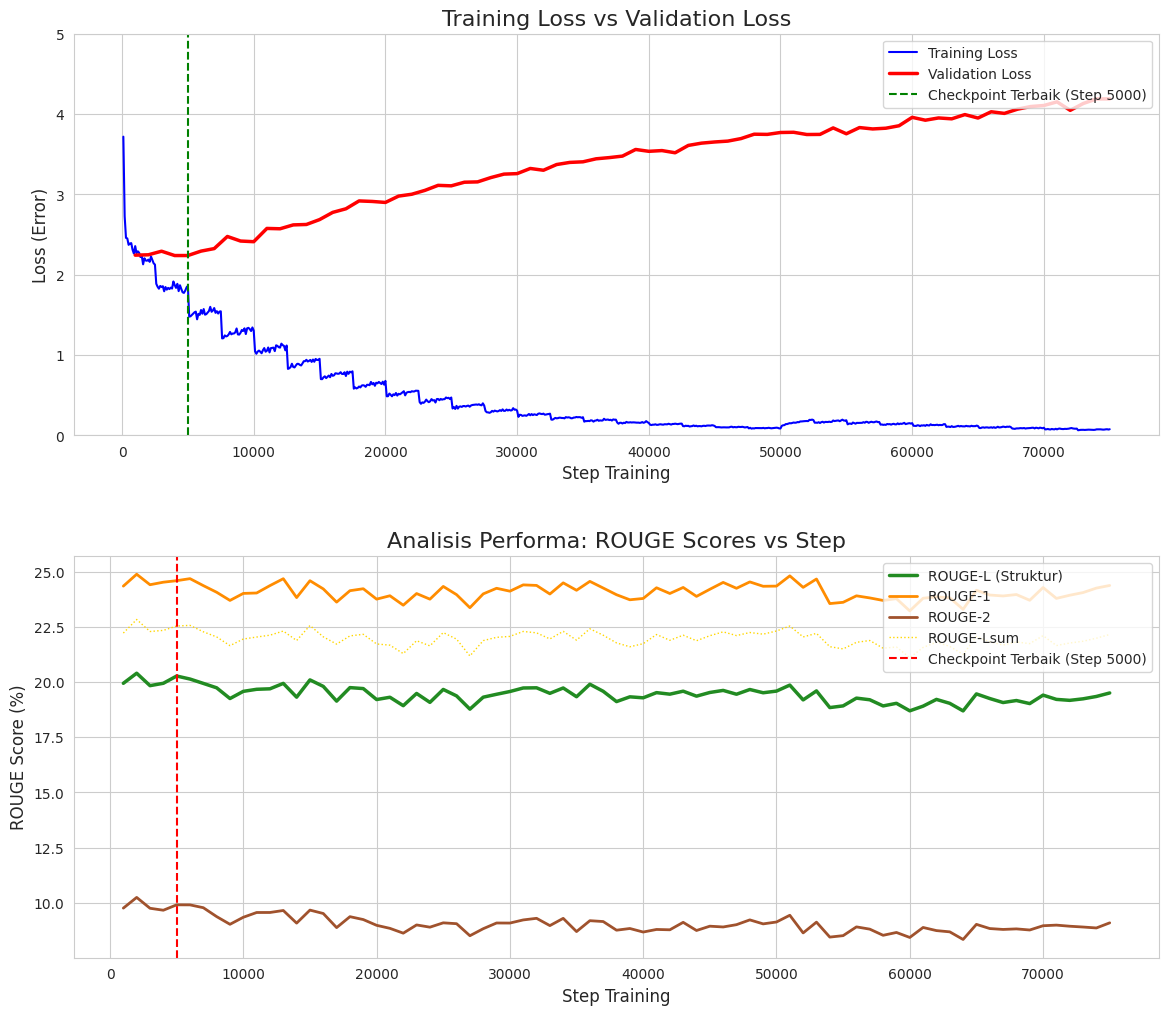


✅ Grafik 75000 Steps tersimpan di Drive: /content/drive/MyDrive/BART_NLP_30EPOCHS_FARHAN/full_75k_analysis_graph.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

# Path output training di Drive
DRIVE_OUTPUT_DIR = "/content/drive/MyDrive/BART_NLP_30EPOCHS_FARHAN"
# LOKASI BARU: Kita ambil dari folder checkpoint terakhir (75000)
TRAINER_STATE_PATH = os.path.join(DRIVE_OUTPUT_DIR, "checkpoint-75000", "trainer_state.json")

print(f"--- 1. Membaca data log LENGKAP dari {TRAINER_STATE_PATH} ---")

# Membaca data log
try:
    with open(TRAINER_STATE_PATH, 'r') as f:
        trainer_state = json.load(f)
    log_history = trainer_state.get('log_history', [])

except FileNotFoundError:
    print(f"ERROR: File log trainer_state.json TIDAK DITEMUKAN di {TRAINER_STATE_PATH}. Mohon cek path Anda!")
    log_history = []

# Membuat DataFrame dari log evaluasi
df_log = pd.DataFrame(log_history)

# --- FILTERING PALING AMAN (Hanya ambil yang punya 'step' dan 'loss' atau 'eval_loss') ---
df_log = df_log.dropna(subset=['step']).copy() # Pastikan kolom 'step' ada
df_log.dropna(subset=['loss', 'eval_loss'], how='all', inplace=True)

# Filter untuk plot
df_train_loss = df_log.dropna(subset=['loss']).rename(columns={'loss': 'Training Loss'})
df_eval = df_log.dropna(subset=['eval_loss']).copy()

print(f"Data Training Log ditemukan: {len(df_train_loss)} entries.")
print(f"Data Validation Log ditemukan: {len(df_eval)} entries.")

sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))
plt.subplots_adjust(hspace=0.3)

# Plot 1: Analisis Loss
axes[0].plot(df_train_loss['step'], df_train_loss['Training Loss'], label='Training Loss', color='blue', linewidth=1.5)
axes[0].plot(df_eval['step'], df_eval['eval_loss'], label='Validation Loss', color='red', linewidth=2.5)

axes[0].axvline(x=5000, color='green', linestyle='--', linewidth=1.5, label='Checkpoint Terbaik (Step 5000)')

axes[0].set_title('Training Loss vs Validation Loss', fontsize=16)
axes[0].set_xlabel('Step Training', fontsize=12)
axes[0].set_ylabel('Loss (Error)', fontsize=12)
axes[0].set_ylim(0, 5.0)
axes[0].legend(loc='upper right', fontsize=10)


# Plot 2: Analisis Performa (ROUGE Scores)
axes[1].plot(df_eval['step'], df_eval['eval_rougeL'], label='ROUGE-L (Struktur)', color='forestgreen', linewidth=2.5)
axes[1].plot(df_eval['step'], df_eval['eval_rouge1'], label='ROUGE-1', color='darkorange', linewidth=2)
axes[1].plot(df_eval['step'], df_eval['eval_rouge2'], label='ROUGE-2', color='sienna', linewidth=2)
axes[1].plot(df_eval['step'], df_eval['eval_rougeLsum'], label='ROUGE-Lsum', color='gold', linestyle=':', linewidth=1)

axes[1].axvline(x=5000, color='red', linestyle='--', linewidth=1.5, label='Checkpoint Terbaik (Step 5000)')

axes[1].set_title('Analisis Performa: ROUGE Scores vs Step', fontsize=16)
axes[1].set_xlabel('Step Training', fontsize=12)
axes[1].set_ylabel('ROUGE Score (%)', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)


plt.show()

# Simpan Gambar Grafik ke Drive
PLOT_PATH = os.path.join(DRIVE_OUTPUT_DIR, "full_75k_analysis_graph.png")
fig.savefig(PLOT_PATH)
print(f"\n✅ Grafik 75000 Steps tersimpan di Drive: {PLOT_PATH}")


In [ ]:
print("--- CONTOH HASIL GENERASI BART (TEST SET) ---")
print("Data ini diambil dari 5 sampel pertama Test Set Anda (1000 data).")
print("==============================================================\n")

test_samples = raw_datasets['test'].select(range(5))

for i in range(5):
    # Dapatkan artikel input asli dari raw_datasets
    artikel_input = test_samples[i]['article']

    # Dapatkan headline referensi dan prediksi dari hasil evaluasi
    headline_referensi = reference_summaries[i]
    headline_prediksi = predicted_summaries[i]

    print(f"--- CONTOH KE-{i+1} ---")
    print(f"**Artikel Asli (Input)**: {artikel_input[:300]}...") # Tampilkan 300 karakter pertama
    print(f"**Headline Referensi (Target)**: {headline_referensi}")
    print(f"**Headline Prediksi BART**: {headline_prediksi}")
    print("-" * 50)

--- CONTOH HASIL GENERASI BART (TEST SET) ---
Data ini diambil dari 5 sampel pertama Test Set Anda (1000 data).

--- CONTOH KE-1 ---
**Artikel Asli (Input)**: (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the cou...
**Headline Referensi (Target)**: Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .
Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis .
**Headline Prediksi BART**: Palestinians signed the ICC's founding Rome Statute in January .
They accepted jurisdiction over alleged crimes committed "in the occupied Palestinian territory"
The ICC opened a preliminary examination into the situation in Palestinian terri

In [ ]:
# --- FUNGSI UJI ZERO-SHOT GENERASI HEADLINE ---

def generate_custom_headline(text_input, model, tokenizer, device):
    """Mengenerasi headline dari teks input tunggal."""

    # 1. Tokenisasi Input
    input_ids = tokenizer(
        text_input,
        max_length=1024, # Gunakan max length yang sama dengan saat training
        truncation=True,
        padding="max_length", # Padding disesuaikan
        return_tensors="pt"
    ).input_ids.to(device) # Pindahkan ke GPU

    # 2. Generasi Output
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids,
            max_length=150,
            num_beams=4, # Gunakan Beam Search yang sama dengan evaluasi
            length_penalty=2.0,
            early_stopping=True
        )

    # 3. Decode dan Bersihkan
    headline = tokenizer.decode(generated_ids.squeeze(), skip_special_tokens=True)
    return headline


BERITA_BARU_ANDA = """
When introducing Nano Banana Pro, Google touted the AI model's several advantages. Among them, Nano Banana Pro features advanced reasoning capabilities, enhanced knowledge, and real-time information.
“With Gemini 3’s advanced reasoning, Nano Banana Pro not only creates beautiful images, but also helps you create more useful content,” said Google DeepMind Product Manager Naina Raisinghani in a post on Google’s official website."""

# Pindahkan model ke mode evaluasi
best_model.eval()

# Panggil fungsi generasi
headline_prediksi = generate_custom_headline(
    BERITA_BARU_ANDA,
    best_model,
    tokenizer,
    device
)

print("-" * 50)
print("✅ UJI ZERO-SHOT GENERASI HEADLINE")
print("-" * 50)
print(f"Artikel Input ({len(BERITA_BARU_ANDA)} chars): {BERITA_BARU_ANDA[:150]}...")
print(f"\nHEADLINE PREDIKSI BART:")
print(f"\n{headline_prediksi}")
print("-" * 50)

--------------------------------------------------
✅ UJI ZERO-SHOT GENERASI HEADLINE
--------------------------------------------------
Artikel Input (431 chars): 
When introducing Nano Banana Pro, Google touted the AI model's several advantages. Among them, Nano Banana Pro features advanced reasoning capabiliti...

HEADLINE PREDIKSI BART:

Nano Banana Pro features advanced reasoning capabilities, enhanced knowledge, real-time information .
Google DeepMind Product Manager Naina Raisinghani says the AI model helps you create more useful content .
--------------------------------------------------
